# Week 8, Day 3: Feature Engineering for Alpha Signals

## Learning Objectives
- Build predictive features from price/volume data
- Understand look-ahead bias prevention
- Create cross-sectional features
- Apply feature selection methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load data
data_path = '../datasets/raw_data/combined_adjusted_close.csv'
prices = pd.read_csv(data_path, index_col='Date', parse_dates=True)
print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")

Data shape: (1836, 63)
Date range: 2019-01-01 00:00:00 to 2026-01-19 00:00:00


## 1. Technical Indicator Features

**Key principle**: All features must use only past data (shifted by 1 day minimum).

In [2]:
def compute_rsi(series, period=14):
    """Compute RSI indicator."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - 100 / (1 + rs)

def compute_macd(series, fast=12, slow=26, signal=9):
    """Compute MACD and signal line."""
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

def compute_bollinger_bands(series, period=20, std_dev=2):
    """Compute Bollinger Band position."""
    middle = series.rolling(period).mean()
    std = series.rolling(period).std()
    upper = middle + std_dev * std
    lower = middle - std_dev * std
    # Position within bands (-1 to 1)
    position = (series - middle) / (std_dev * std)
    return position

def compute_momentum(series, periods=[5, 10, 20]):
    """Compute momentum at different horizons."""
    result = {}
    for p in periods:
        result[f'mom_{p}d'] = series.pct_change(p)
    return pd.DataFrame(result)

# Test on SPY
spy = prices['SPY']

print("RSI sample:", compute_rsi(spy).iloc[-5:].values)
print("\nMACD sample:", compute_macd(spy)[0].iloc[-5:].values)

RSI sample: [63.44768575 53.57990207 52.8198703  52.01549116 56.13922245]

MACD sample: [4.17166034 3.91405119 3.81758798 3.65223696 3.65223696]


In [3]:
def create_technical_features(price_series):
    """Create comprehensive technical features (all properly lagged)."""
    df = pd.DataFrame(index=price_series.index)
    
    # Returns at multiple horizons
    for period in [1, 2, 3, 5, 10, 20, 60]:
        df[f'ret_{period}d'] = price_series.pct_change(period).shift(1)
    
    # Moving average crossovers
    sma_5 = price_series.rolling(5).mean()
    sma_10 = price_series.rolling(10).mean()
    sma_20 = price_series.rolling(20).mean()
    sma_50 = price_series.rolling(50).mean()
    
    df['sma_5_10_cross'] = ((sma_5 / sma_10) - 1).shift(1)
    df['sma_5_20_cross'] = ((sma_5 / sma_20) - 1).shift(1)
    df['sma_10_50_cross'] = ((sma_10 / sma_50) - 1).shift(1)
    
    # Price position relative to MAs
    df['price_vs_sma20'] = ((price_series / sma_20) - 1).shift(1)
    df['price_vs_sma50'] = ((price_series / sma_50) - 1).shift(1)
    
    # RSI
    df['rsi_14'] = compute_rsi(price_series, 14).shift(1)
    df['rsi_7'] = compute_rsi(price_series, 7).shift(1)
    
    # MACD
    macd, macd_signal = compute_macd(price_series)
    df['macd'] = macd.shift(1)
    df['macd_signal'] = macd_signal.shift(1)
    df['macd_hist'] = (macd - macd_signal).shift(1)
    
    # Bollinger Band position
    df['bb_position'] = compute_bollinger_bands(price_series).shift(1)
    
    # Volatility features
    returns = price_series.pct_change()
    df['volatility_5d'] = returns.rolling(5).std().shift(1)
    df['volatility_20d'] = returns.rolling(20).std().shift(1)
    df['vol_ratio'] = (df['volatility_5d'] / df['volatility_20d'])
    
    # High-low range (using rolling high/low as proxy)
    df['range_20d'] = ((price_series.rolling(20).max() - price_series.rolling(20).min()) / 
                        price_series.rolling(20).mean()).shift(1)
    
    # Distance from highs/lows
    df['dist_from_20d_high'] = ((price_series / price_series.rolling(20).max()) - 1).shift(1)
    df['dist_from_20d_low'] = ((price_series / price_series.rolling(20).min()) - 1).shift(1)
    
    # Target
    df['target_return'] = price_series.pct_change().shift(-1)
    df['target_direction'] = (df['target_return'] > 0).astype(int)
    
    return df.dropna()

# Create features for SPY
spy_features = create_technical_features(prices['SPY'])
print(f"Total features created: {len([c for c in spy_features.columns if 'target' not in c])}")
print(f"\nFeature names:")
print([c for c in spy_features.columns if 'target' not in c])

Total features created: 24

Feature names:
['ret_1d', 'ret_2d', 'ret_3d', 'ret_5d', 'ret_10d', 'ret_20d', 'ret_60d', 'sma_5_10_cross', 'sma_5_20_cross', 'sma_10_50_cross', 'price_vs_sma20', 'price_vs_sma50', 'rsi_14', 'rsi_7', 'macd', 'macd_signal', 'macd_hist', 'bb_position', 'volatility_5d', 'volatility_20d', 'vol_ratio', 'range_20d', 'dist_from_20d_high', 'dist_from_20d_low']


## 2. Cross-Sectional Features

Features that compare a stock to its peers (useful for stock selection).

In [4]:
def create_cross_sectional_features(prices_df, ticker):
    """
    Create features that rank a stock vs the universe.
    """
    features = pd.DataFrame(index=prices_df.index)
    
    # Calculate returns for all stocks
    returns_1d = prices_df.pct_change(1)
    returns_5d = prices_df.pct_change(5)
    returns_20d = prices_df.pct_change(20)
    
    # Cross-sectional rank (0 to 1)
    def rank_vs_universe(series):
        return series.rank(axis=1, pct=True)
    
    features['rank_ret_1d'] = rank_vs_universe(returns_1d)[ticker].shift(1)
    features['rank_ret_5d'] = rank_vs_universe(returns_5d)[ticker].shift(1)
    features['rank_ret_20d'] = rank_vs_universe(returns_20d)[ticker].shift(1)
    
    # Relative strength vs market (SPY)
    features['rel_strength_1d'] = (returns_1d[ticker] - returns_1d['SPY']).shift(1)
    features['rel_strength_5d'] = (returns_5d[ticker] - returns_5d['SPY']).shift(1)
    
    # Z-score vs universe
    def zscore_vs_universe(returns):
        mean = returns.mean(axis=1)
        std = returns.std(axis=1)
        return (returns[ticker] - mean) / std
    
    features['zscore_ret_1d'] = zscore_vs_universe(returns_1d).shift(1)
    features['zscore_ret_5d'] = zscore_vs_universe(returns_5d).shift(1)
    
    # Momentum rank change
    rank_5d = rank_vs_universe(returns_5d)[ticker]
    features['rank_change_5d'] = (rank_5d - rank_5d.shift(5)).shift(1)
    
    return features.dropna()

# Create cross-sectional features for AAPL
cs_features = create_cross_sectional_features(prices, 'AAPL')
print("Cross-sectional features:")
print(cs_features.tail())

Cross-sectional features:
            rank_ret_1d  rank_ret_5d  rank_ret_20d  rel_strength_1d  \
Date                                                                  
2026-01-13     0.603175     0.095238      0.031746         0.001822   
2026-01-14     0.539683     0.365079      0.031746         0.005073   
2026-01-15     0.396825     0.365079      0.063492         0.000740   
2026-01-16     0.206349     0.285714      0.063492        -0.009455   
2026-01-19     0.158730     0.269841      0.063492        -0.009541   

            rel_strength_5d  zscore_ret_1d  zscore_ret_5d  rank_change_5d  
Date                                                                       
2026-01-13        -0.037048       0.037932      -1.309198       -0.079365  
2026-01-14        -0.007826       0.249119      -0.375694        0.333333  
2026-01-15        -0.002552      -0.227453      -0.377999        0.317460  
2026-01-16        -0.007164      -0.632872      -0.413112        0.269841  
2026-01-19        -0

## 3. Combining Features and Preparing Data

In [5]:
def create_full_feature_set(prices_df, ticker):
    """Combine technical and cross-sectional features."""
    
    # Technical features
    tech_features = create_technical_features(prices_df[ticker])
    
    # Cross-sectional features
    cs_features = create_cross_sectional_features(prices_df, ticker)
    
    # Combine
    combined = tech_features.join(cs_features, how='inner')
    
    return combined

# Create full feature set for AAPL
aapl_data = create_full_feature_set(prices, 'AAPL')
feature_cols = [c for c in aapl_data.columns if 'target' not in c]

print(f"Total features: {len(feature_cols)}")
print(f"Samples: {len(aapl_data)}")

Total features: 32
Samples: 90


## 4. Feature Selection Methods

In [6]:
# Prepare data
X = aapl_data[feature_cols]
y = aapl_data['target_direction']

# Train/test split (time-based)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Handle any infinities
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"Training: {len(X_train)}, Test: {len(X_test)}")

Training: 72, Test: 18


In [7]:
# Method 1: Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_ranking = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("Feature Ranking by Mutual Information")
print("="*50)
print(mi_ranking.head(15).to_string(index=False))

Feature Ranking by Mutual Information
        feature  mi_score
    bb_position  0.095976
        ret_20d  0.087667
  volatility_5d  0.072791
rel_strength_1d  0.070492
 rank_change_5d  0.068250
 price_vs_sma20  0.062893
    macd_signal  0.059855
        ret_60d  0.048397
        ret_10d  0.040433
  zscore_ret_1d  0.037612
sma_10_50_cross  0.027816
    rank_ret_5d  0.023111
 sma_5_10_cross  0.022383
         ret_3d  0.022035
           macd  0.016685


In [8]:
# Method 2: Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Ranking by Random Forest Importance")
print("="*50)
print(rf_importance.head(15).to_string(index=False))


Feature Ranking by Random Forest Importance
           feature  importance
 dist_from_20d_low    0.073505
       bb_position    0.052934
    price_vs_sma20    0.050398
           ret_60d    0.044541
       macd_signal    0.037521
    rank_change_5d    0.036585
         macd_hist    0.036423
         range_20d    0.034183
     volatility_5d    0.034120
     zscore_ret_1d    0.032694
       rank_ret_5d    0.032628
dist_from_20d_high    0.031348
            ret_5d    0.030551
    sma_5_20_cross    0.030023
   sma_10_50_cross    0.029860


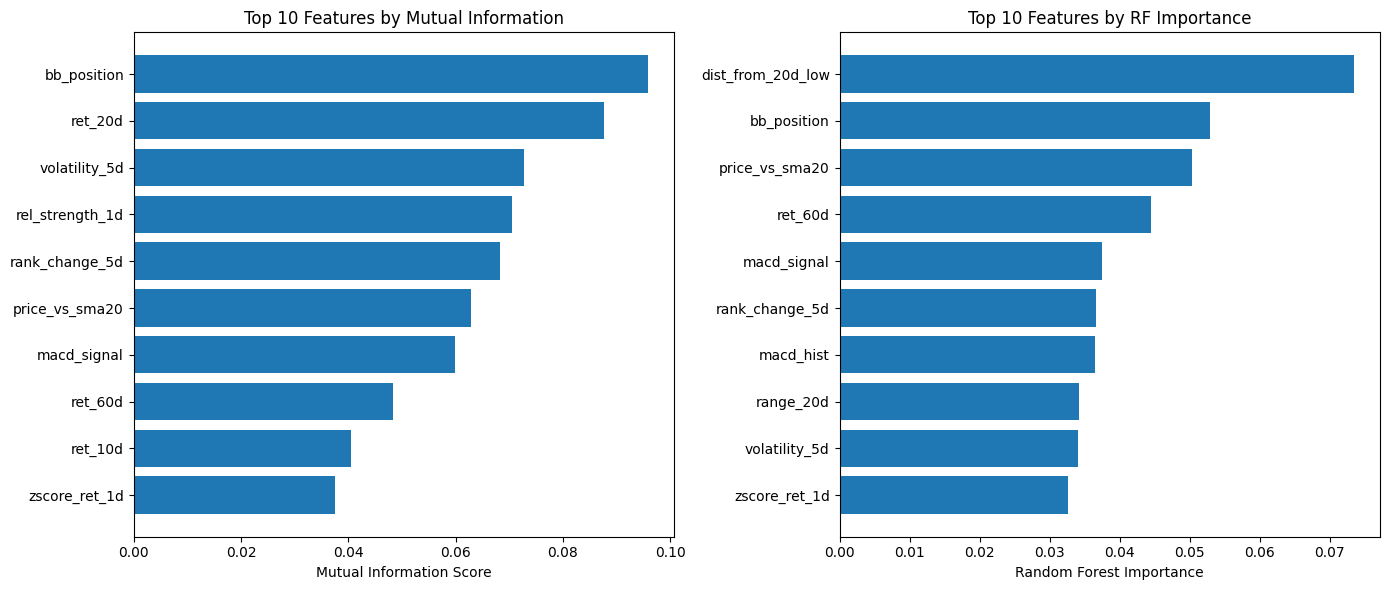

In [9]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MI scores
top_mi = mi_ranking.head(10)
axes[0].barh(top_mi['feature'], top_mi['mi_score'])
axes[0].set_xlabel('Mutual Information Score')
axes[0].set_title('Top 10 Features by Mutual Information')
axes[0].invert_yaxis()

# RF importance
top_rf = rf_importance.head(10)
axes[1].barh(top_rf['feature'], top_rf['importance'])
axes[1].set_xlabel('Random Forest Importance')
axes[1].set_title('Top 10 Features by RF Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Model Performance with Selected Features

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Compare: All features vs Top 10
top_10_features = rf_importance.head(10)['feature'].tolist()

results = []

# All features
model_all = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_all.fit(X_train, y_train)
results.append({
    'Feature Set': 'All Features',
    'n_features': len(feature_cols),
    'Train Acc': model_all.score(X_train, y_train),
    'Test Acc': model_all.score(X_test, y_test)
})

# Top 10 features
model_top10 = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_top10.fit(X_train[top_10_features], y_train)
results.append({
    'Feature Set': 'Top 10 Features',
    'n_features': 10,
    'Train Acc': model_top10.score(X_train[top_10_features], y_train),
    'Test Acc': model_top10.score(X_test[top_10_features], y_test)
})

# Top 5 features
top_5_features = rf_importance.head(5)['feature'].tolist()
model_top5 = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_top5.fit(X_train[top_5_features], y_train)
results.append({
    'Feature Set': 'Top 5 Features',
    'n_features': 5,
    'Train Acc': model_top5.score(X_train[top_5_features], y_train),
    'Test Acc': model_top5.score(X_test[top_5_features], y_test)
})

print("Feature Selection Impact on Model Performance")
print("="*65)
print(pd.DataFrame(results).to_string(index=False))

Feature Selection Impact on Model Performance
    Feature Set  n_features  Train Acc  Test Acc
   All Features          32   1.000000  0.555556
Top 10 Features          10   1.000000  0.722222
 Top 5 Features           5   0.958333  0.777778


## 6. Checking for Look-Ahead Bias

In [11]:
def verify_no_lookahead(feature_df, target_col='target_direction'):
    """
    Verify that features don't have look-ahead bias.
    If features can perfectly predict target, something is wrong.
    """
    from sklearn.linear_model import LogisticRegression
    
    feature_cols = [c for c in feature_df.columns if 'target' not in c]
    X = feature_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = feature_df[target_col]
    
    # Very simple model should not get >60% accuracy
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    accuracy = model.score(X, y)
    
    print(f"Simple logistic regression accuracy: {accuracy:.4f}")
    
    if accuracy > 0.70:
        print("⚠️  WARNING: Suspiciously high accuracy! Check for look-ahead bias.")
        # Find most predictive features
        importance = np.abs(model.coef_[0])
        top_idx = np.argsort(importance)[-5:]
        print("Most predictive features (check these):")
        for idx in top_idx:
            print(f"  - {feature_cols[idx]}: coef={model.coef_[0][idx]:.4f}")
    else:
        print("✓ No obvious look-ahead bias detected.")
    
    return accuracy

# Verify our features
verify_no_lookahead(aapl_data)

Simple logistic regression accuracy: 0.6667
✓ No obvious look-ahead bias detected.


0.6666666666666666

## 7. Practice Exercises

1. **New Features**: Add volume-based features (if available) or sentiment features.

2. **Feature Correlation**: Remove highly correlated features to reduce redundancy.

3. **Regime Features**: Create features that identify market regimes (high/low vol).

4. **Lagged Features**: Experiment with different lag periods.

In [12]:
# Exercise: Feature correlation analysis
feature_corr = X_train.corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if feature_corr.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'feature_1': feature_corr.columns[i],
                'feature_2': feature_corr.columns[j],
                'correlation': feature_corr.iloc[i, j]
            })

print("Highly Correlated Feature Pairs (>0.8)")
print("="*60)
if high_corr_pairs:
    print(pd.DataFrame(high_corr_pairs).to_string(index=False))
else:
    print("No highly correlated pairs found.")

Highly Correlated Feature Pairs (>0.8)
      feature_1          feature_2  correlation
         ret_1d    rel_strength_1d     0.856374
         ret_1d      zscore_ret_1d     0.828720
         ret_5d        rank_ret_5d     0.863841
         ret_5d    rel_strength_5d     0.869033
         ret_5d      zscore_ret_5d     0.863083
        ret_20d       rank_ret_20d     0.810264
        ret_60d    sma_10_50_cross     0.895941
        ret_60d     price_vs_sma50     0.861437
sma_10_50_cross     price_vs_sma50     0.897309
sma_10_50_cross        macd_signal     0.885852
 price_vs_sma20              rsi_7     0.822989
 price_vs_sma20        bb_position     0.853063
 price_vs_sma50               macd     0.846525
 price_vs_sma50        macd_signal     0.847668
           macd        macd_signal     0.889850
    bb_position dist_from_20d_high     0.825107
      range_20d  dist_from_20d_low     0.884929
    rank_ret_1d    rel_strength_1d     0.845796
    rank_ret_1d      zscore_ret_1d     0.892450
 

## Summary

Today we learned:
- Technical features (RSI, MACD, Bollinger Bands, etc.)
- Cross-sectional features (ranks, z-scores vs universe)
- Feature selection using MI and RF importance
- How to check for look-ahead bias
- More features isn't always better - selection helps generalization